# Overview 

### Each topic outputs a set of genes with a score. Scanpy.tl.score_genes and the PCa cell signatures from H.Song were used to rank cell types within each topic.  The highest ranked genes and cell types per topic were used for futher analysis.

Imports 

In [1]:
import pandas as pd 
import scanpy as sc 
import numpy as np


Load  cell pie output - topics x genes 

In [2]:
sc.set_figure_params(scanpy=True, dpi=250, dpi_save=300)

In [3]:
iac_path = '/Users/user/Desktop/CellPie_paper/Revision/prostate_loadings_reproduce.h5ad' 
iac_adata = sc.read(iac_path)

In [4]:
iac_adata

AnnData object with n_obs × n_vars = 26 × 12968

Load PCa cell type signatures from H.Song - https://www.nature.com/articles/s41467-021-27322-4

In [9]:
def load_cell_type_signatures():

    # Load PCa signature 
    cell_type_signatures = pd.read_excel('Data/Cell_type_markers.xlsx', 'PCa signature') # SET PATH TO cell_type_markers 

    # Combine markers from ERGneg and ERGpos tumour to tumour 
    # Find union between markers 
    erg_neg = cell_type_signatures['ERGneg_Tumor'].dropna().values
    erg_pos = cell_type_signatures['ERGpos_Tumor'].dropna().values
    tumour = np.hstack((erg_pos,erg_neg))

    # Attach NAN to end to match length of other signatures 
    tumour = np.unique(tumour).reshape(1,-1)
    end_attch = np.array(['NaN'] * (205-93)).reshape(1,-1)

    # Combine and replace ERGpos Tumor, ERGneg Tumor with Tumor  in original df 
    tumour = np.hstack((tumour, end_attch))
    cell_type_signatures = cell_type_signatures.drop(['ERGpos_Tumor', 'ERGneg_Tumor'], axis=1)
    cell_type_signatures['Tumor'] = tumour[0]
    return cell_type_signatures


In [10]:
cell_type_signatures = load_cell_type_signatures()
cell_type_signatures

BE     Club     LE Endothelial Fibroblast Smooth_muscle T-cells  \
0      KRT15     MMP7   MSMB         VWF        DCN         MYH11    IL7R   
1       KRT5     PIGR   ACPP        SELE      FBLN1          RGS5   TRBC2   
2      KRT13    OLFM4   NEFH       IFI27     COL1A2         ACTA2    CCL5   
3    SLC14A1       CP   ORM1        FLT1       IGF1         TAGLN    IFNG   
4        DST  RARRES1  ANPEP     SPARCL1         C7          MYL9    CD8A   
..       ...      ...    ...         ...        ...           ...     ...   
200      NaN      NaN    NaN         NaN        NaN           NaN     NaN   
201      NaN      NaN    NaN         NaN        NaN           NaN     NaN   
202      NaN      NaN    NaN         NaN        NaN           NaN     NaN   
203      NaN      NaN    NaN         NaN        NaN           NaN     NaN   
204      NaN      NaN    NaN         NaN        NaN           NaN     NaN   

      Myeloid Neurons  B-cells    Tumor  
0        IL1B    S100B    IGKC      A2M  
1     HLA-DRA    NRXN1   CD79A     AGR2  
2    HLA-DPA1     SOX2   CXCR4  ALDH1A3  
3    HLA-DPB1    SOX10    CD37    ARL5B  
4    HLA-DRB1      NaN   MS4A1  CACNA1D  
..        ...      ...     ...      ...  
200     PLCB2      NaN     NaN      NaN  
201      EMR2      NaN     NaN      NaN  
202  C10orf54      NaN     NaN      NaN  
203  SERPINA1      NaN     NaN      NaN  
204  PPP1R15A      NaN     NaN      NaN  

[205 rows x 11 columns]

In [11]:
def score_celltypes_per_topic(iac_adata, cell_type_signatures):
    ''' Uses topic score for each gene to rank cell types per topic'''
    
    # Cell type to be scored 
    cell_names = cell_type_signatures.columns.tolist()
    
    # Assign score for each cell type add to adata 
    for i in cell_names: 
        cell_genes = cell_type_signatures[i].values
        sc.tl.score_genes(iac_adata, cell_genes, score_name=i)
    
    return iac_adata 
    

In [12]:
iac_adata = score_celltypes_per_topic(iac_adata, cell_type_signatures)

         'PDLIM1',     'PTRF',  'FAM198B', 'C10orf10', 'KIAA1462',   'PPAP2B',
           'KLF2',    'TMTC1',     'MKL2',    'SSFA2',     'CD59',  'C1QTNF5',
           'CTGF',  'SEC14L1',        nan],
      dtype='object')
                  'GPR124',              'CTGF',              'IGF2',
       2020-09-11 00:00:00,             'CYR61',              'LHFP',
                  'TUBA1A',             'ADH1B',                 nan],
      dtype='object')
         'GPR124',  'C2orf40',    'CASQ2',     'MYL6', 'C10orf10',  'GUCY1B3',
        'FAM129A',     'SELM',     'LHFP',   'PPAP2B',   'TMEM47',    'NRIP2',
           'KLF2',        nan],
      dtype='object')
                'FYB',         'GZMB',      'PTPRCAP',          'TNF',
             'FAM46C', 'RP11-94L15.2',       'BCL11B',         'GZMH',
              'CRTAM',        'TMEM2',        'KLRB1',         'CD48',
               'CD97',         'CCR5',        'ITGAE',        'HLA-B',
                  nan],
      dtype='object')
 

Create excel file containing ranked cell types and genes per topic with score

In [13]:
def rank_celltype_in_topic(topic_n, adata):
    ''' Ranks cell types based of topic score '''
    print('TOPIC ', topic_n)
    topic_col = adata.obs.iloc[topic_n,1:].sort_values(ascending=False)
    topic_col.columns = ['sc.tl.score_gene']
    return topic_col

In [14]:
def find_top_n_markers(topic_marker_genes, topic, n_genes): 
    ''' Finds all or N top genes per topic '''
    topic_N = topic_marker_genes.iloc[:,[0,(topic+1)]]
    topic_N_ngenes = topic_N.sort_values(by='Topic_'+str(topic), ascending=False)
    topic_N_ngenes.columns = ['Genes', 'Topic score']
    return topic_N_ngenes

In [60]:
iac_adata.shape[0]

26

In [15]:
import pandas as pd
topic_path = '/Users/user/Desktop/CellPie_paper/Revision/marker_genes_prostate.csv' # SET PATH to marker_genes_prostate_cancer_invasive_9topics_svd_normalised.csv
def load_topic_csv(topic_path):
    # Load csv 
    topic_marker_genes = pd.read_csv(topic_path)
    
    # Add columns 
    topic_names = ['Topic_'+str(i) for i in range(iac_adata.shape[0])]
    column_names = ['Genes']
    column_names.extend(topic_names)
    topic_marker_genes.columns = column_names
    return topic_marker_genes

topic_marker_genes = load_topic_csv(topic_path)

In [16]:
topic_marker_genes

Genes   Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
0        KLK3  5.022081  1.253017  0.312364  0.613781  3.709192  0.350502   
1        KLK2  4.680423  1.189575  0.183432  0.526095  3.242754  0.316761   
2         UBC  4.285092  1.165997  0.892623  0.634441  1.718425  0.564347   
3        EEF2  4.284831  1.293012  0.481443  0.727631  1.635666  0.488736   
4      PABPC1  3.621803  1.031632  0.745143  0.688578  1.183551  0.557160   
...       ...       ...       ...       ...       ...       ...       ...   
12963   CDH10  0.000000  0.000000  0.000000  0.015372  0.062506  0.093943   
12964    CDH6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12965   THAP2  0.000000  0.011635  0.025877  0.000000  0.063405  0.008656   
12966  ZFC3H1  0.000000  0.330349  0.257003  0.151457  0.173071  0.044074   
12967  SAMD11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        Topic_6   Topic_7   Topic_8  ...  Topic_16  Topic_17  Topic_18  \
0      1.113068  1.291581  0.800284  ...  0.998292  0.914476  3.820592   
1      1.008112  1.146038  0.637181  ...  0.832168  0.816742  3.184316   
2      0.741126  1.148535  0.717756  ...  1.585857  0.280043  3.804370   
3      0.910263  0.959126  0.511061  ...  1.078364  0.346351  2.814181   
4      0.766933  0.772097  0.400897  ...  0.802718  0.342005  2.028988   
...         ...       ...       ...  ...       ...       ...       ...   
12963  0.088330  0.000000  0.001175  ...  0.227153  0.000000  0.000000   
12964  0.006091  0.000000  0.000000  ...  0.044654  0.000000  0.000000   
12965  0.026345  0.000000  0.000000  ...  0.000000  0.000000  0.023251   
12966  0.169623  0.014941  0.091869  ...  0.116067  0.110004  0.312577   
12967  0.052540  0.006969  0.110446  ...  0.094116  0.059578  0.080330   

       Topic_19  Topic_20  Topic_21  Topic_22  Topic_23  Topic_24  Topic_25  
0      0.624236  2.047845  0.938804  0.448091  0.253969  0.136396  0.016259  
1      0.804325  2.064454  1.050335  0.360400  0.213898  0.082435  0.015957  
2      0.448900  1.165402  0.730513  0.536808  0.827206  0.258916  0.066356  
3      1.085463  2.302164  0.599529  0.497510  0.529127  0.188010  0.403936  
4      0.677018  2.174618  0.428825  0.446897  0.304164  0.210532  0.243024  
...         ...       ...       ...       ...       ...       ...       ...  
12963  0.000000  0.000000  0.000000  0.000000  0.000000  0.001453  0.116026  
12964  0.000000  0.033933  0.000000  0.000000  0.078282  0.101524  0.000000  
12965  0.093647  0.067155  0.023152  0.001660  0.000000  0.021504  0.000000  
12966  0.027212  0.501394  0.114982  0.080792  0.142826  0.114440  0.102491  
12967  0.000000  0.000000  0.112672  0.000000  0.160411  0.000000  0.000000  

[12968 rows x 27 columns]

In [17]:
def results_output():
    ''' Creates two excel files to store results: 
    1. ranked_celltypes_per_topic.xlsx
    2. ranked_celltypes_per_topic.xlsx '''

    # Generate ranked / scored cell types and genes per topic 
    celltype_rank_dict = {} 
    top_markers_dict = {} 

    for i in range(iac_adata.shape[0]):
        celltype_rank_dict[i] = rank_celltype_in_topic(i,iac_adata)
        top_markers_dict[i] = find_top_n_markers(topic_marker_genes, i, n_genes=5)
    # # Save to excel
    # with pd.ExcelWriter('ranked_celltypes_per_topic_PC_prostate_reprod_14topics_new.xlsx') as writer:
    #     for i in range(iac_adata.shape[0]): 
    #         celltype_rank_dict[i].to_excel(writer, sheet_name='topic_' + str(i))

    # with pd.ExcelWriter('ranked_genes_per_topic_PC_prostate_reprod_14topics_new.xlsx') as writer:
    #     for i in range(iac_adata.shape[0]): 
    #         top_markers_dict[i].to_excel(writer, sheet_name='topic_' + str(i))
    return celltype_rank_dict,top_markers_dict


In [18]:
ct,mg=results_output()

TOPIC  0
TOPIC  1
TOPIC  2
TOPIC  3
TOPIC  4
TOPIC  5
TOPIC  6
TOPIC  7
TOPIC  8
TOPIC  9
TOPIC  10
TOPIC  11
TOPIC  12
TOPIC  13
TOPIC  14
TOPIC  15
TOPIC  16
TOPIC  17
TOPIC  18
TOPIC  19
TOPIC  20
TOPIC  21
TOPIC  22
TOPIC  23
TOPIC  24
TOPIC  25


([<matplotlib.axis.XTick at 0x31b5c8980>,
 [Text(0.0, 0, 'KLK3'),
  Text(1.0, 0, 'KLK2'),
  Text(2.0, 0, 'UBC'),
  Text(3.0, 0, 'EEF2'),
  Text(4.0, 0, 'PABPC1'),
  Text(5.0, 0, 'ACTB'),
  Text(6.0, 0, 'SERF2'),
  Text(7.0, 0, 'EEF1G'),
  Text(8.0, 0, 'RACK1'),
  Text(9.0, 0, 'UBA52')])

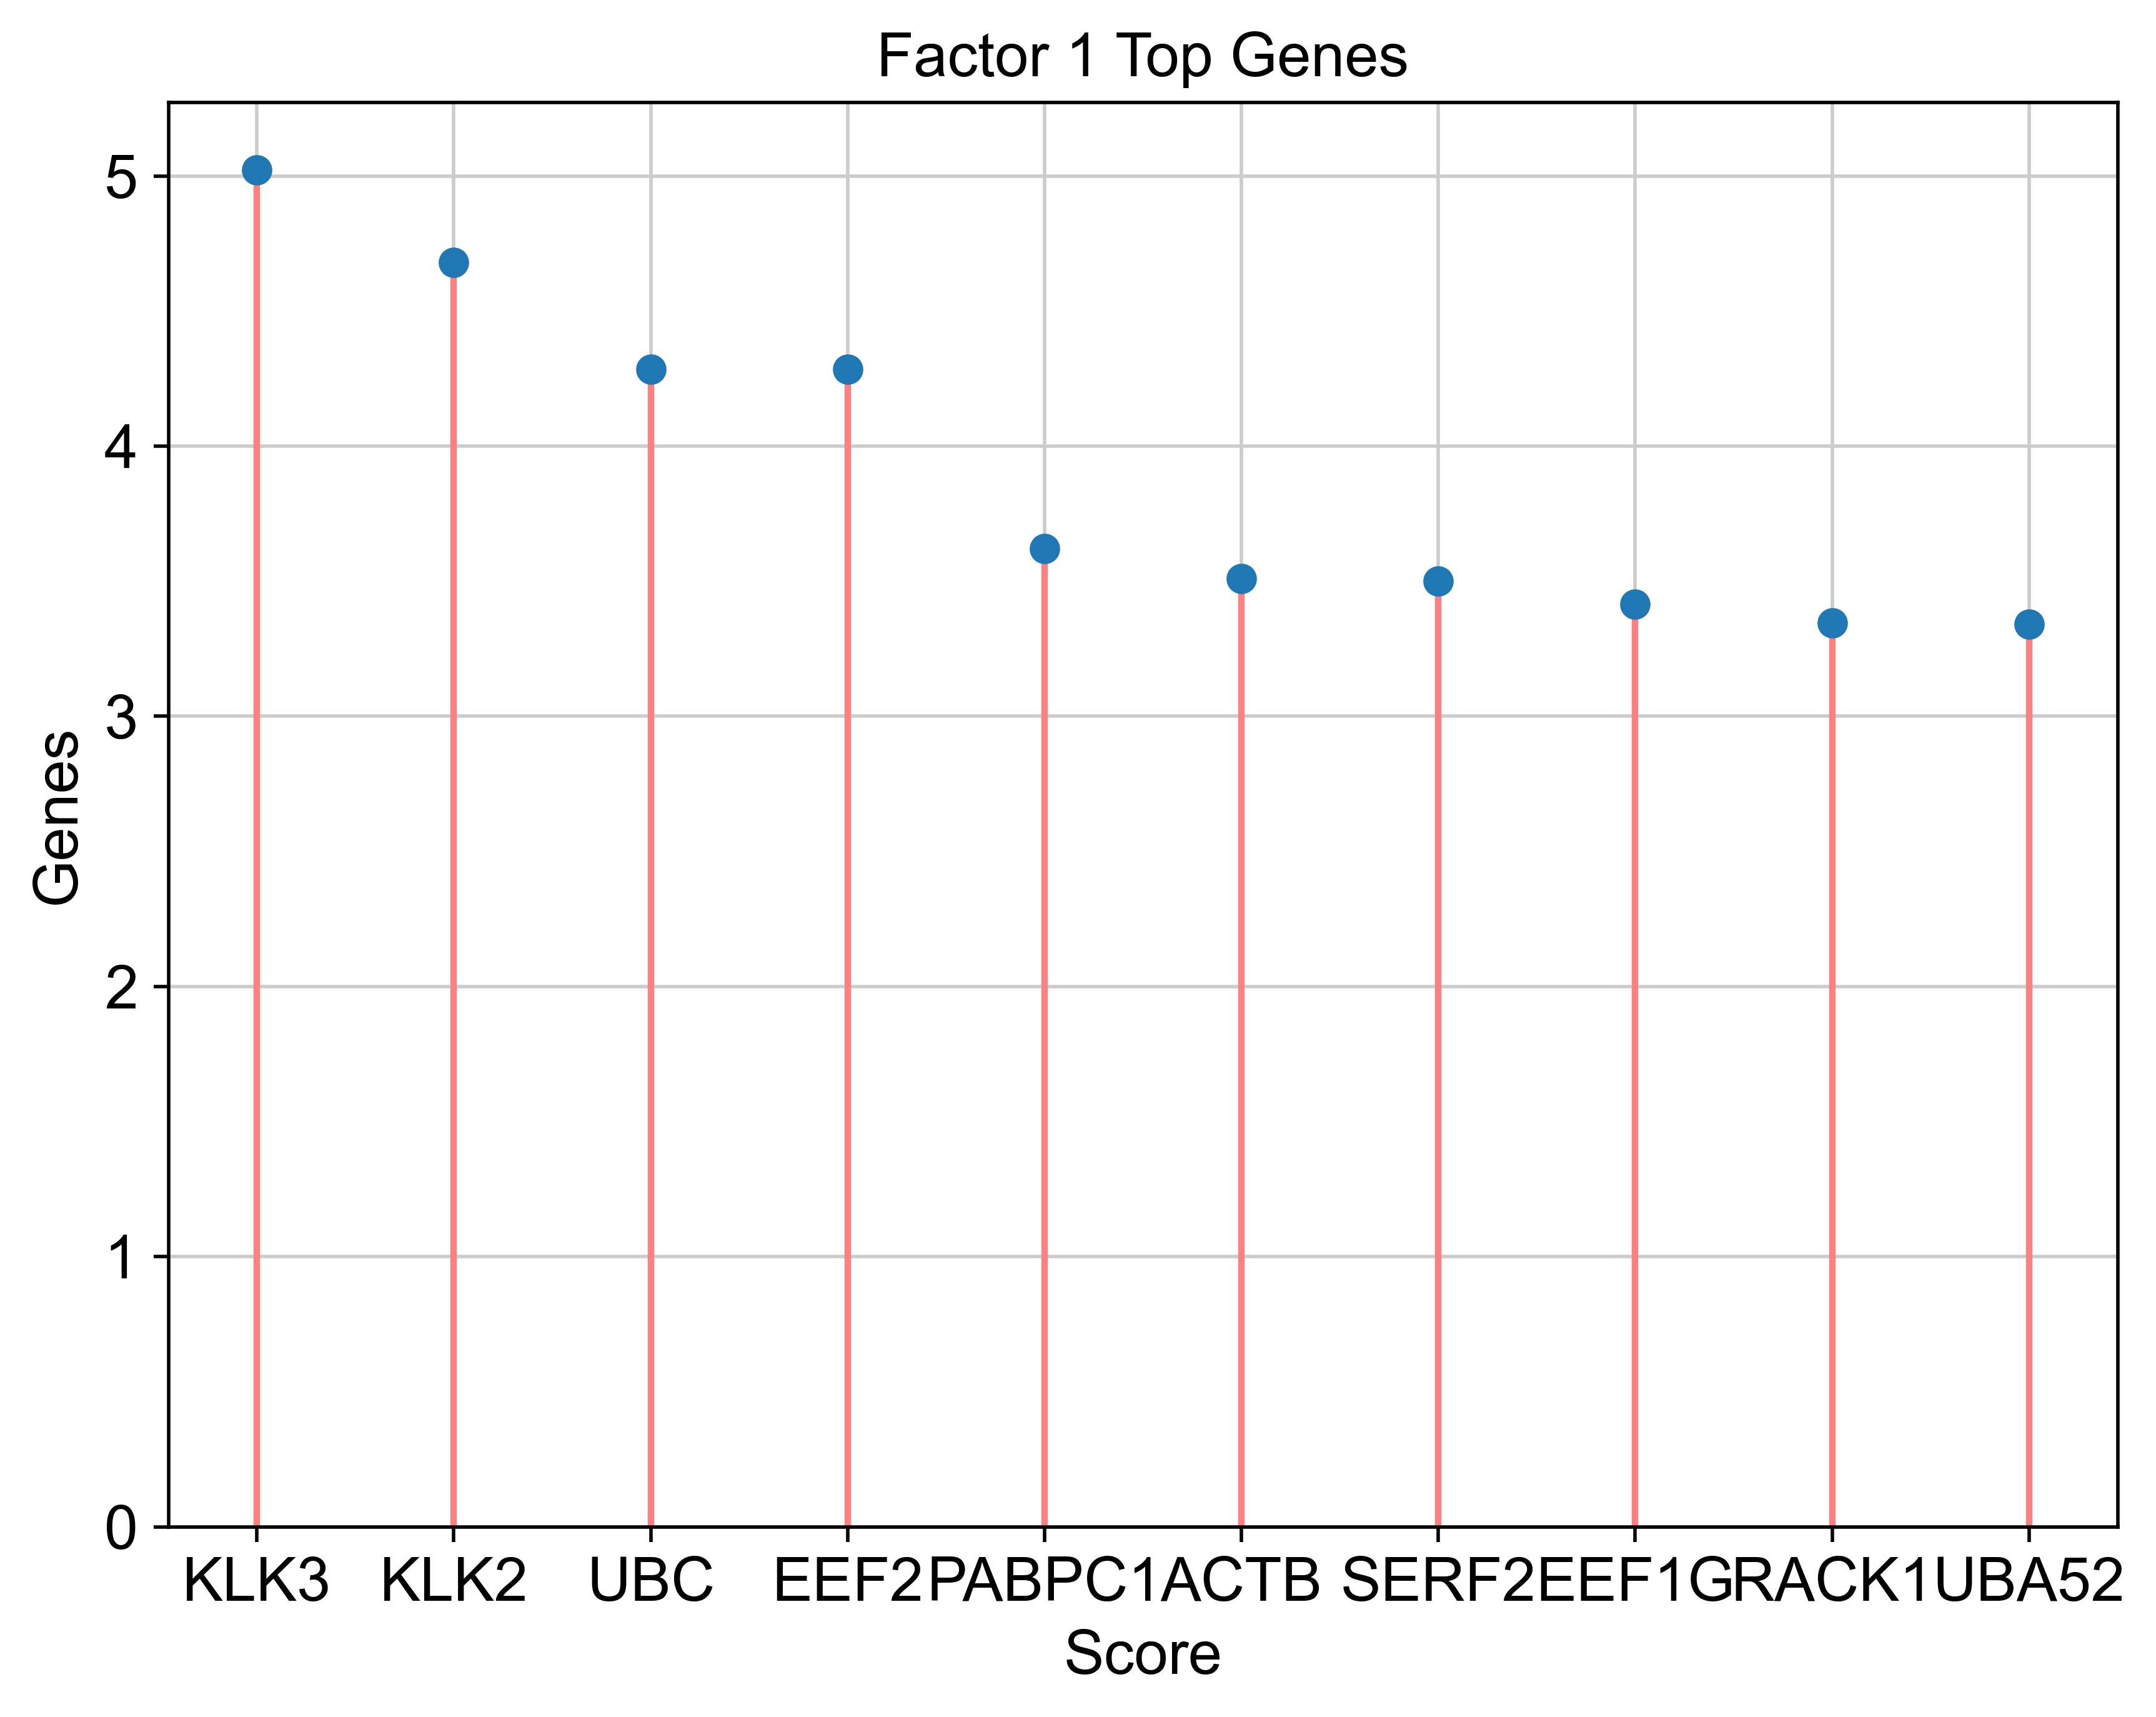

In [19]:
from pandas import *
from matplotlib import pyplot as plt 

fig, axes = plt.subplots(figsize=(8, 6)) 
axes.vlines(mg[0]['Genes'].iloc[0:10], ymin=0, ymax=mg[0]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[0]['Genes'].iloc[0:10], mg[0]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 1 Top Genes') 
plt.xticks(mg[0]['Genes'].iloc[0:10])

([<matplotlib.axis.XTick at 0x31b758320>,
 [Text(0.0, 0, 'KRT15'),
  Text(1.0, 0, 'KRT7'),
  Text(2.0, 0, 'KRT5'),
  Text(3.0, 0, 'OLFM4'),
  Text(4.0, 0, 'LTF'),
  Text(5.0, 0, 'MMP7'),
  Text(6.0, 0, 'WFDC2'),
  Text(7.0, 0, 'ELF3'),
  Text(8.0, 0, 'S100A6'),
  Text(9.0, 0, 'TRIM29')])

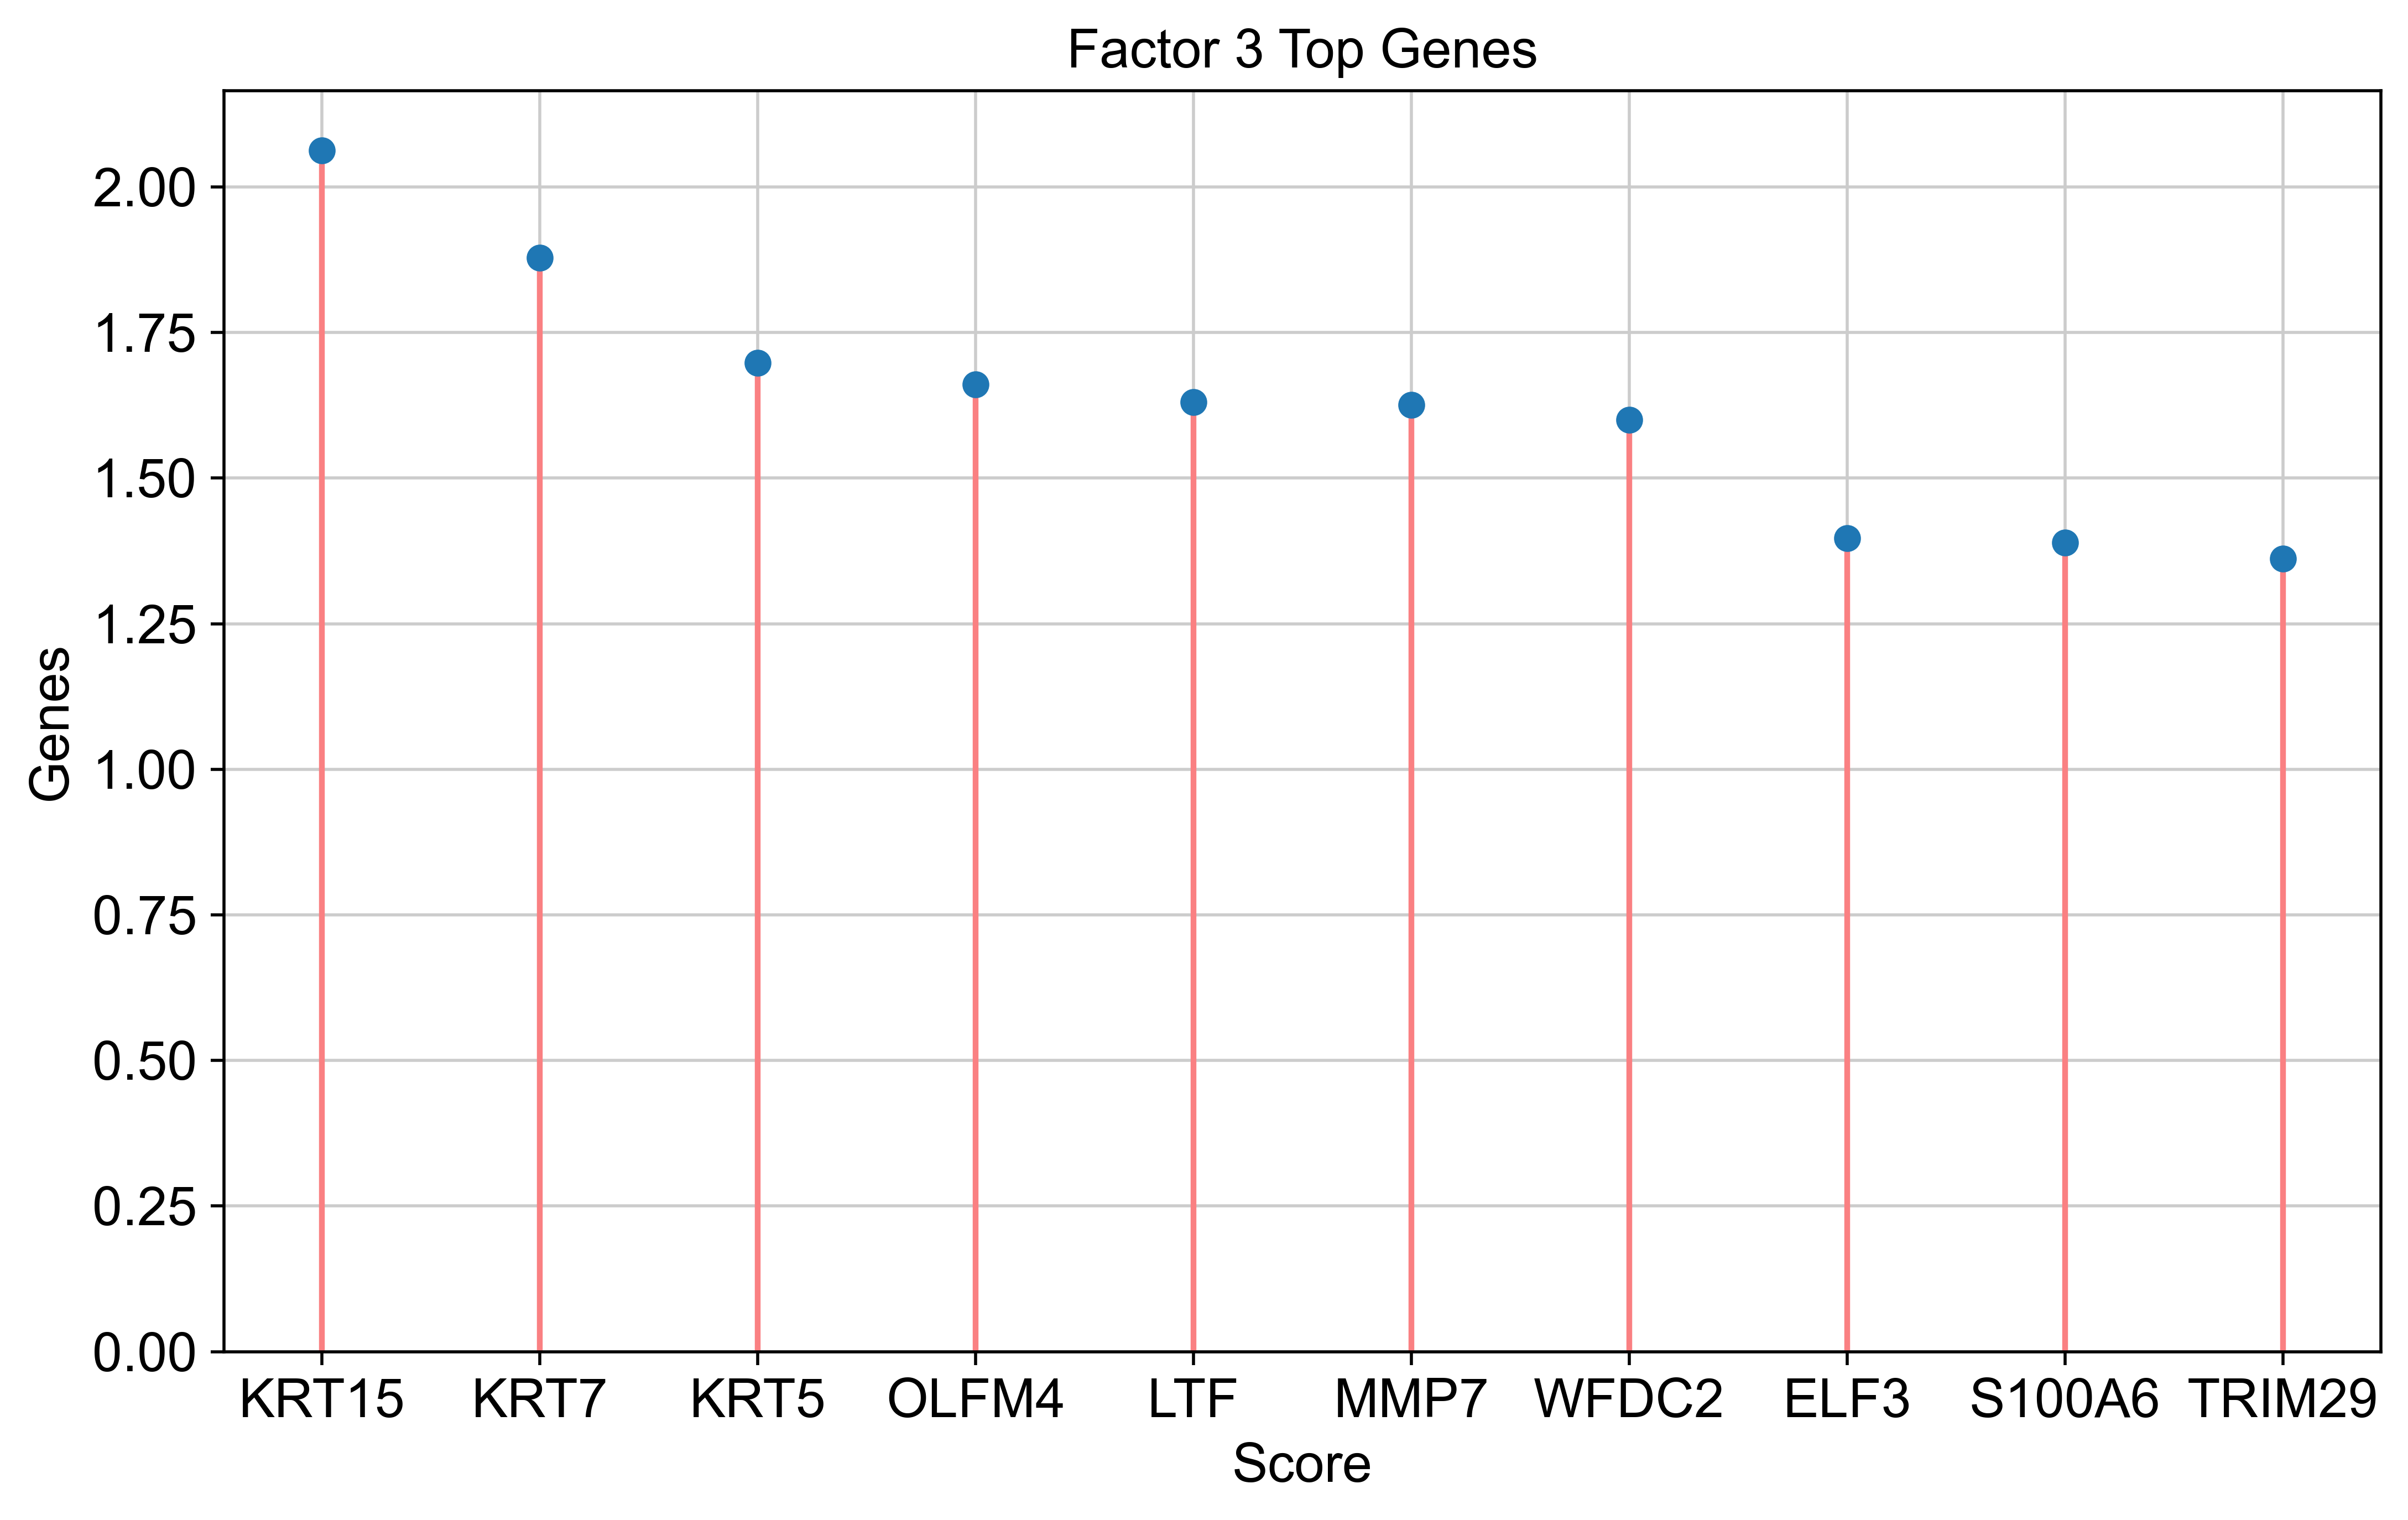

In [20]:

fig, axes = plt.subplots(figsize=(10, 6)) 
i=2
axes.vlines(mg[i]['Genes'].iloc[0:10], ymin=0, ymax=mg[i]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[i]['Genes'].iloc[0:10], mg[i]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
  
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 3 Top Genes') 
plt.xticks(mg[i]['Genes'].iloc[0:10])

([<matplotlib.axis.XTick at 0x31b75a9f0>,
 [Text(0.0, 0, 'KLK3'),
  Text(1.0, 0, 'OR51E2'),
  Text(2.0, 0, 'TMEFF2'),
  Text(3.0, 0, 'AMACR'),
  Text(4.0, 0, 'NPY'),
  Text(5.0, 0, 'KLK2'),
  Text(6.0, 0, 'OR51C1P'),
  Text(7.0, 0, 'PLPP1'),
  Text(8.0, 0, 'RDH11'),
  Text(9.0, 0, 'MCCC2')])

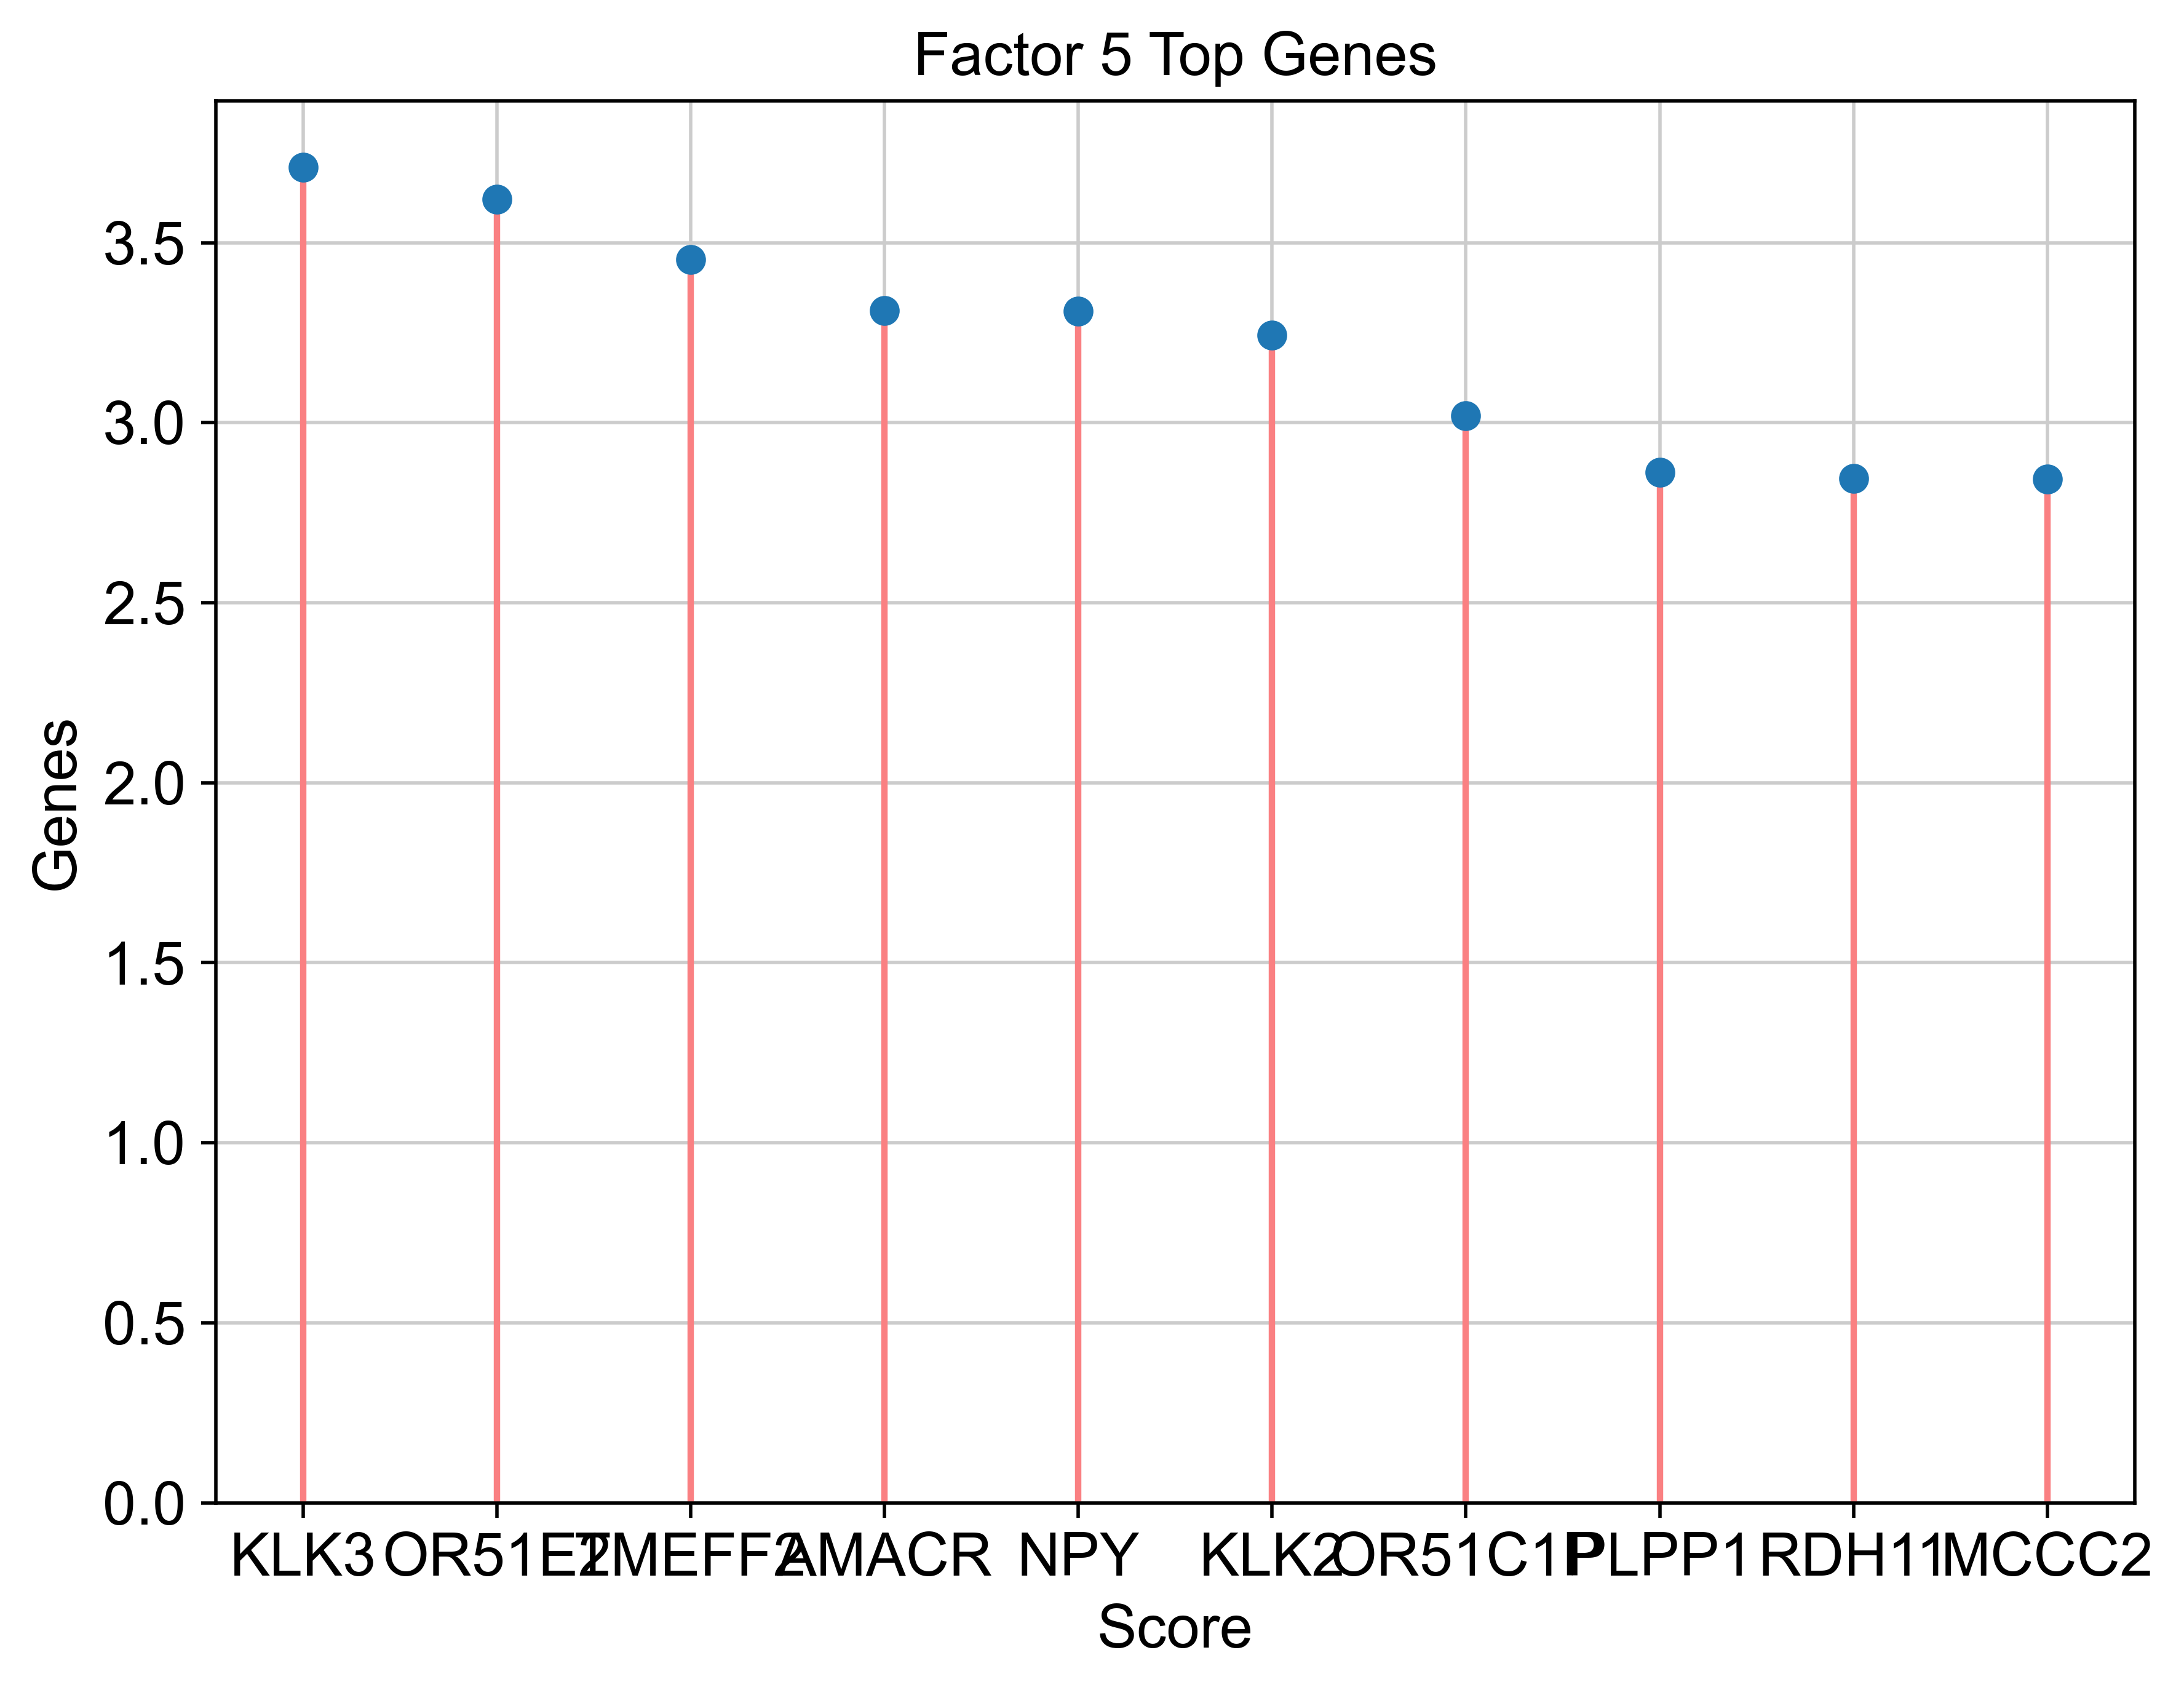

In [21]:

fig, axes = plt.subplots(figsize=(8, 6)) 
i=4
axes.vlines(mg[i]['Genes'].iloc[0:10], ymin=0, ymax=mg[i]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[i]['Genes'].iloc[0:10], mg[i]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
  
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 5 Top Genes') 
plt.xticks(mg[i]['Genes'].iloc[0:10])

([<matplotlib.axis.XTick at 0x32a1e8140>,
 [Text(0.0, 0, 'MSMB'),
  Text(1.0, 0, 'NEFH'),
  Text(2.0, 0, 'ACPP'),
  Text(3.0, 0, 'AZGP1'),
  Text(4.0, 0, 'KRT15'),
  Text(5.0, 0, 'CDC42EP5'),
  Text(6.0, 0, 'VEGFA'),
  Text(7.0, 0, 'MT1G'),
  Text(8.0, 0, 'LMAN1L'),
  Text(9.0, 0, 'KLK3')])

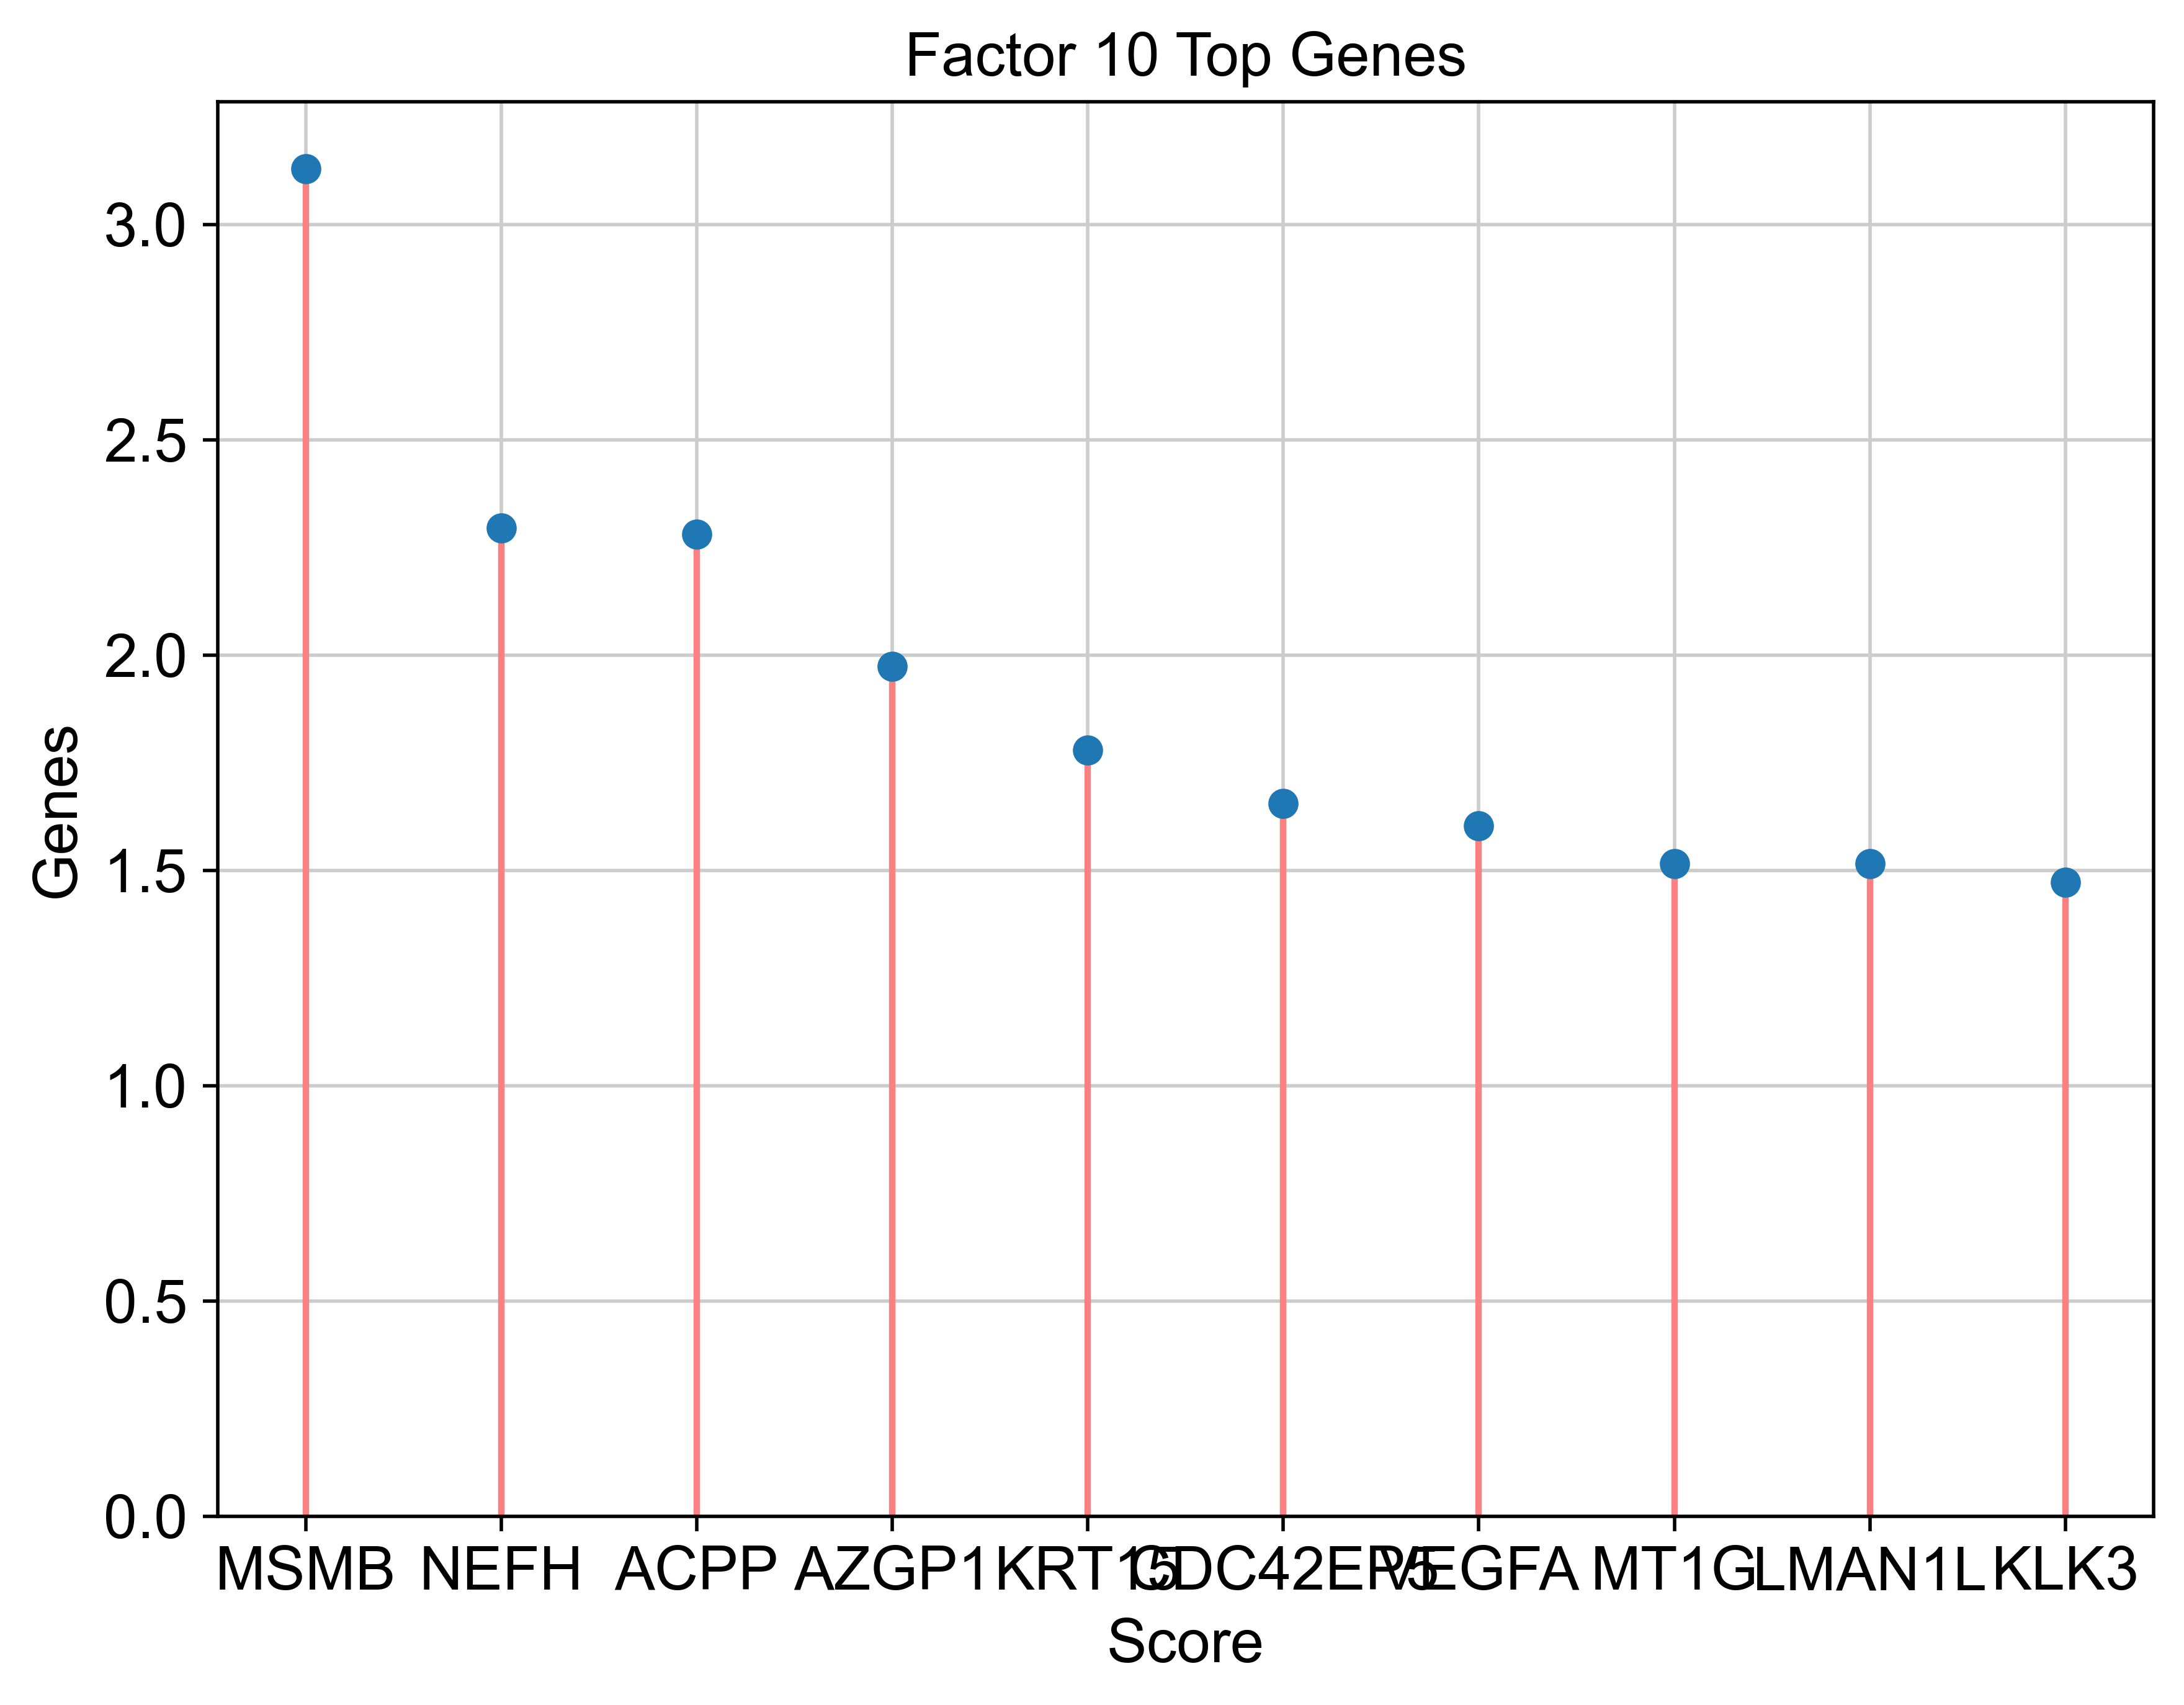

In [22]:

fig, axes = plt.subplots(figsize=(8, 6))  
i=9
axes.vlines(mg[i]['Genes'].iloc[0:10], ymin=0, ymax=mg[i]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[i]['Genes'].iloc[0:10], mg[i]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
  
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 10 Top Genes') 
plt.xticks(mg[i]['Genes'].iloc[0:10])


([<matplotlib.axis.XTick at 0x330e79460>,
 [Text(0.0, 0, 'APOD'),
  Text(1.0, 0, 'S100B'),
  Text(2.0, 0, 'VIM'),
  Text(3.0, 0, 'MPZ'),
  Text(4.0, 0, 'ITGB8'),
  Text(5.0, 0, 'NRXN1'),
  Text(6.0, 0, 'PTGDS'),
  Text(7.0, 0, 'FN1'),
  Text(8.0, 0, 'DCN'),
  Text(9.0, 0, 'S100A6')])

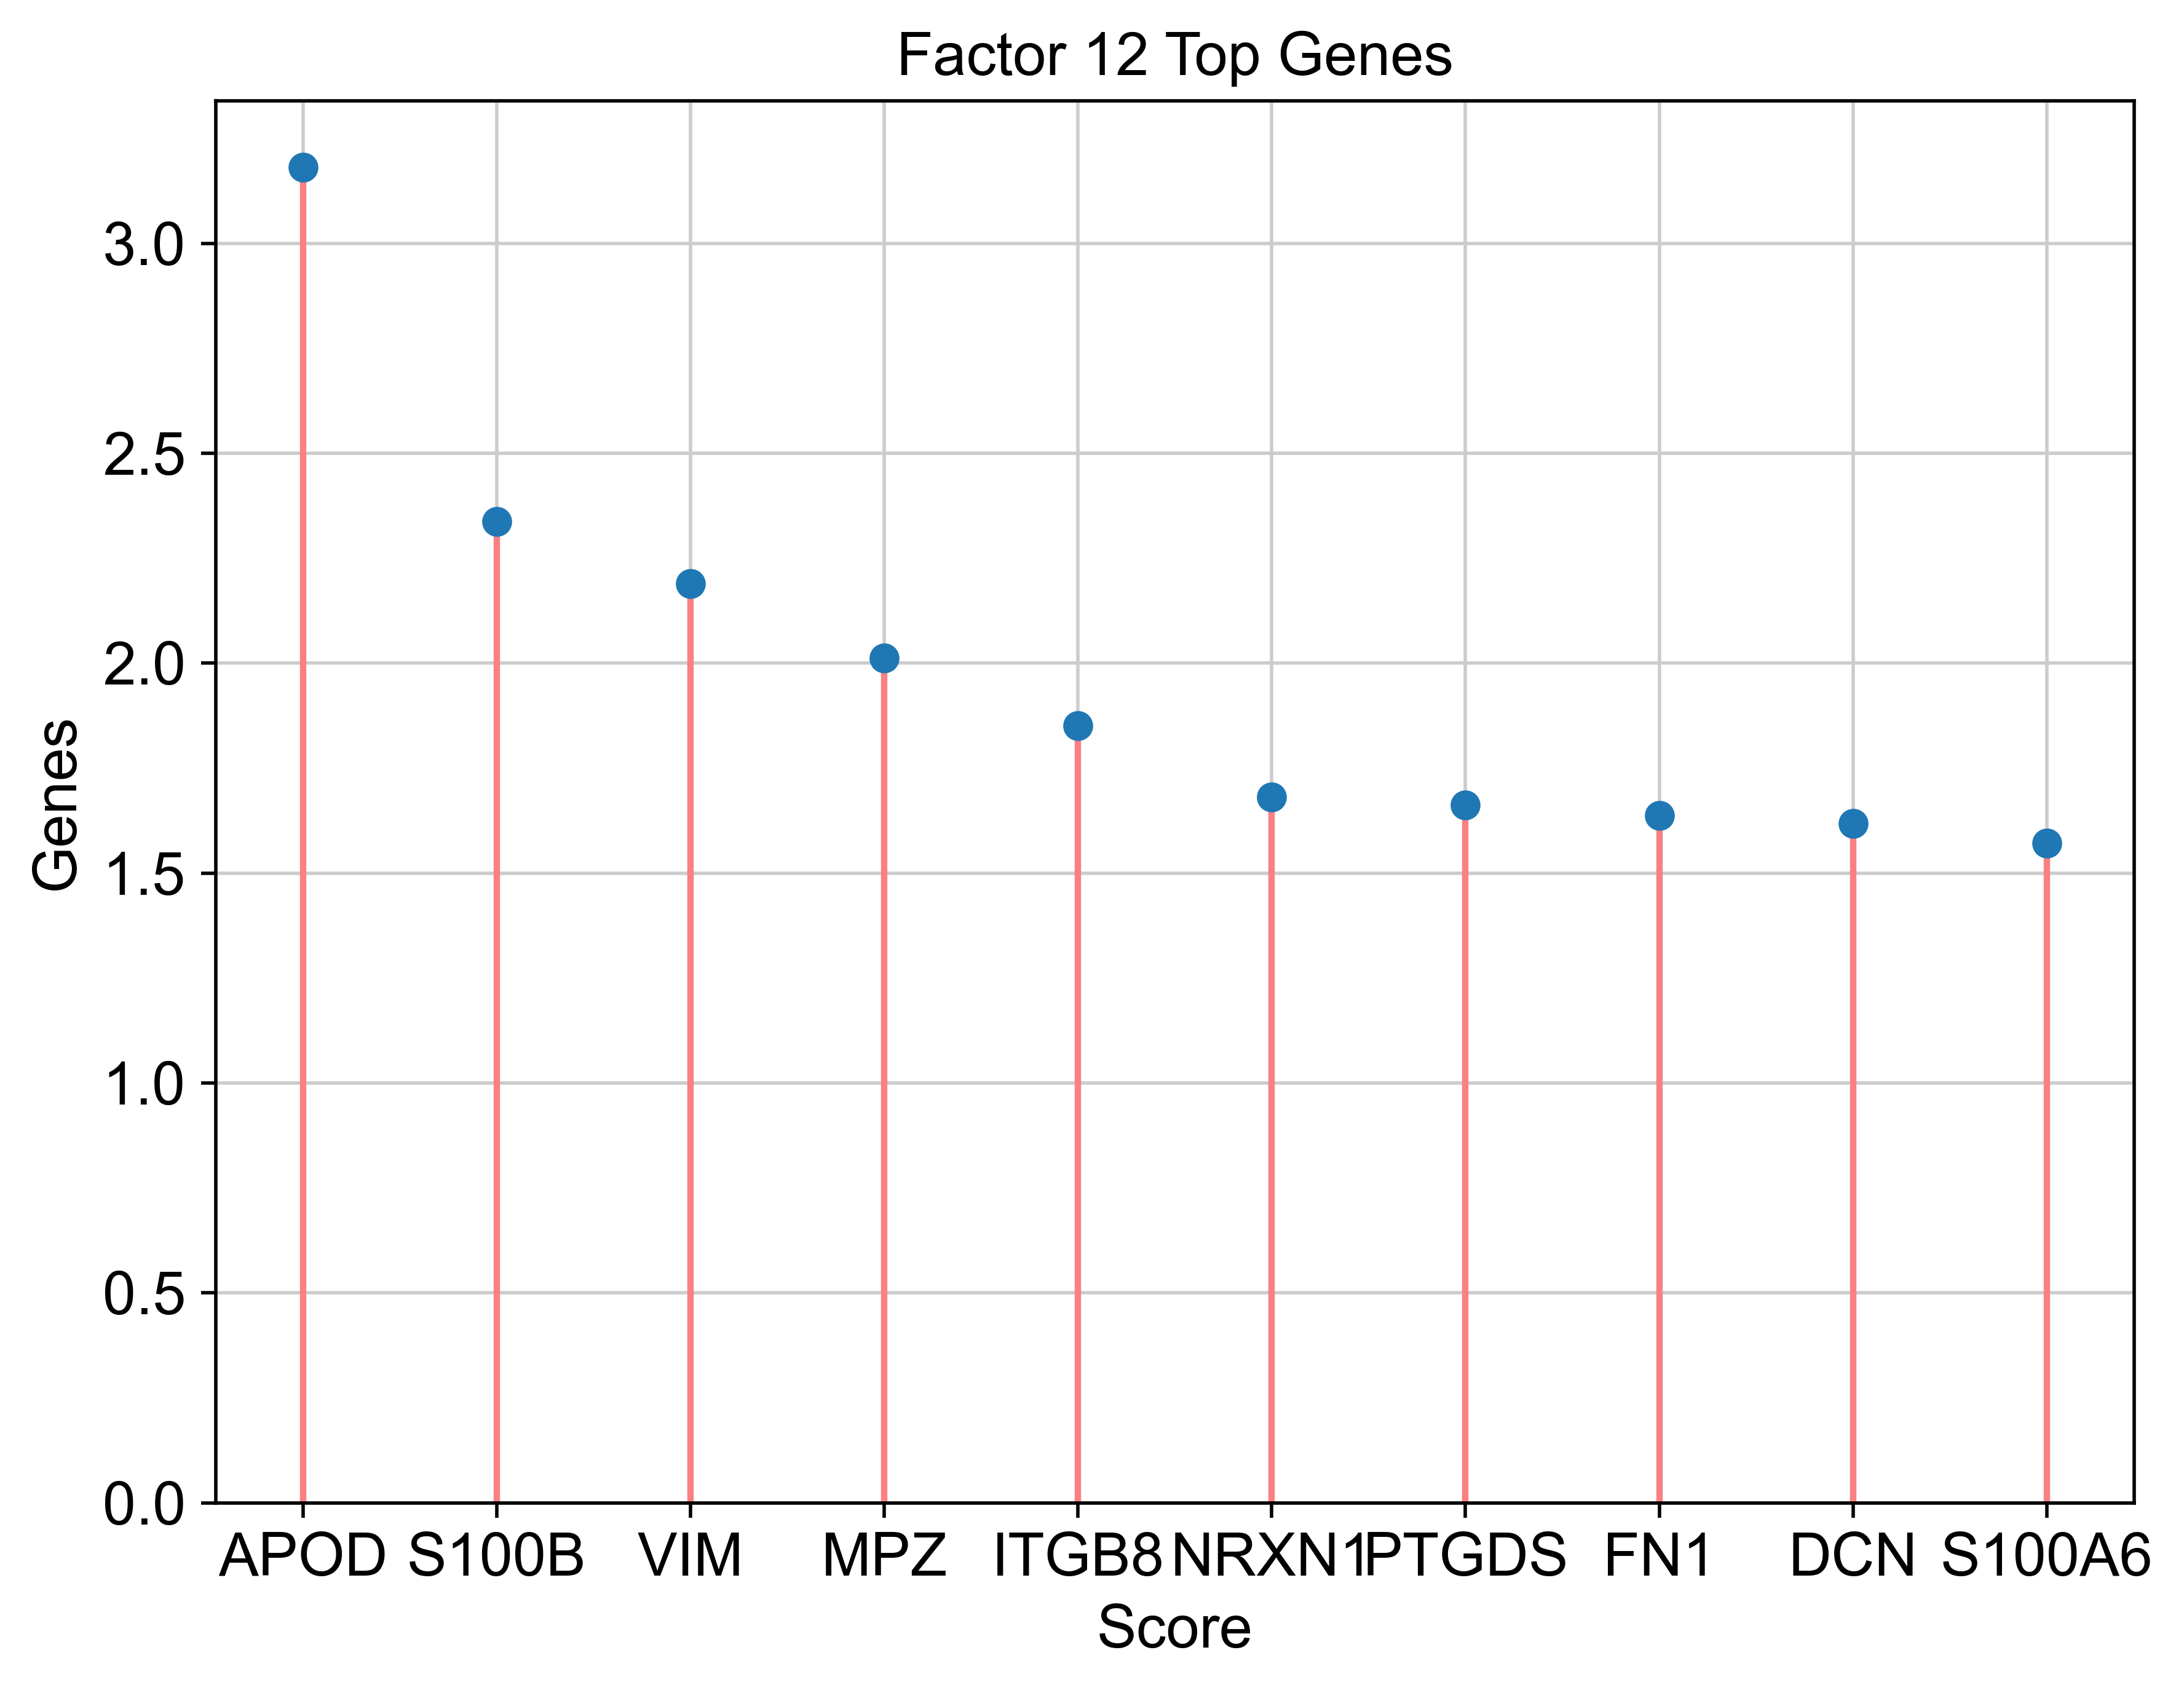

In [23]:

fig, axes = plt.subplots(figsize=(8, 6)) 
i=11
axes.vlines(mg[i]['Genes'].iloc[0:10], ymin=0, ymax=mg[i]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[i]['Genes'].iloc[0:10], mg[i]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
  
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 12 Top Genes') 
plt.xticks(mg[i]['Genes'].iloc[0:10])

([<matplotlib.axis.XTick at 0x330f09190>,
 [Text(0.0, 0, 'ACTG2'),
  Text(1.0, 0, 'MYL9'),
  Text(2.0, 0, 'TAGLN'),
  Text(3.0, 0, 'TPM2'),
  Text(4.0, 0, 'ACTA2'),
  Text(5.0, 0, 'FOSB'),
  Text(6.0, 0, 'JUNB'),
  Text(7.0, 0, 'FLNA'),
  Text(8.0, 0, 'DES'),
  Text(9.0, 0, 'CNN1')])

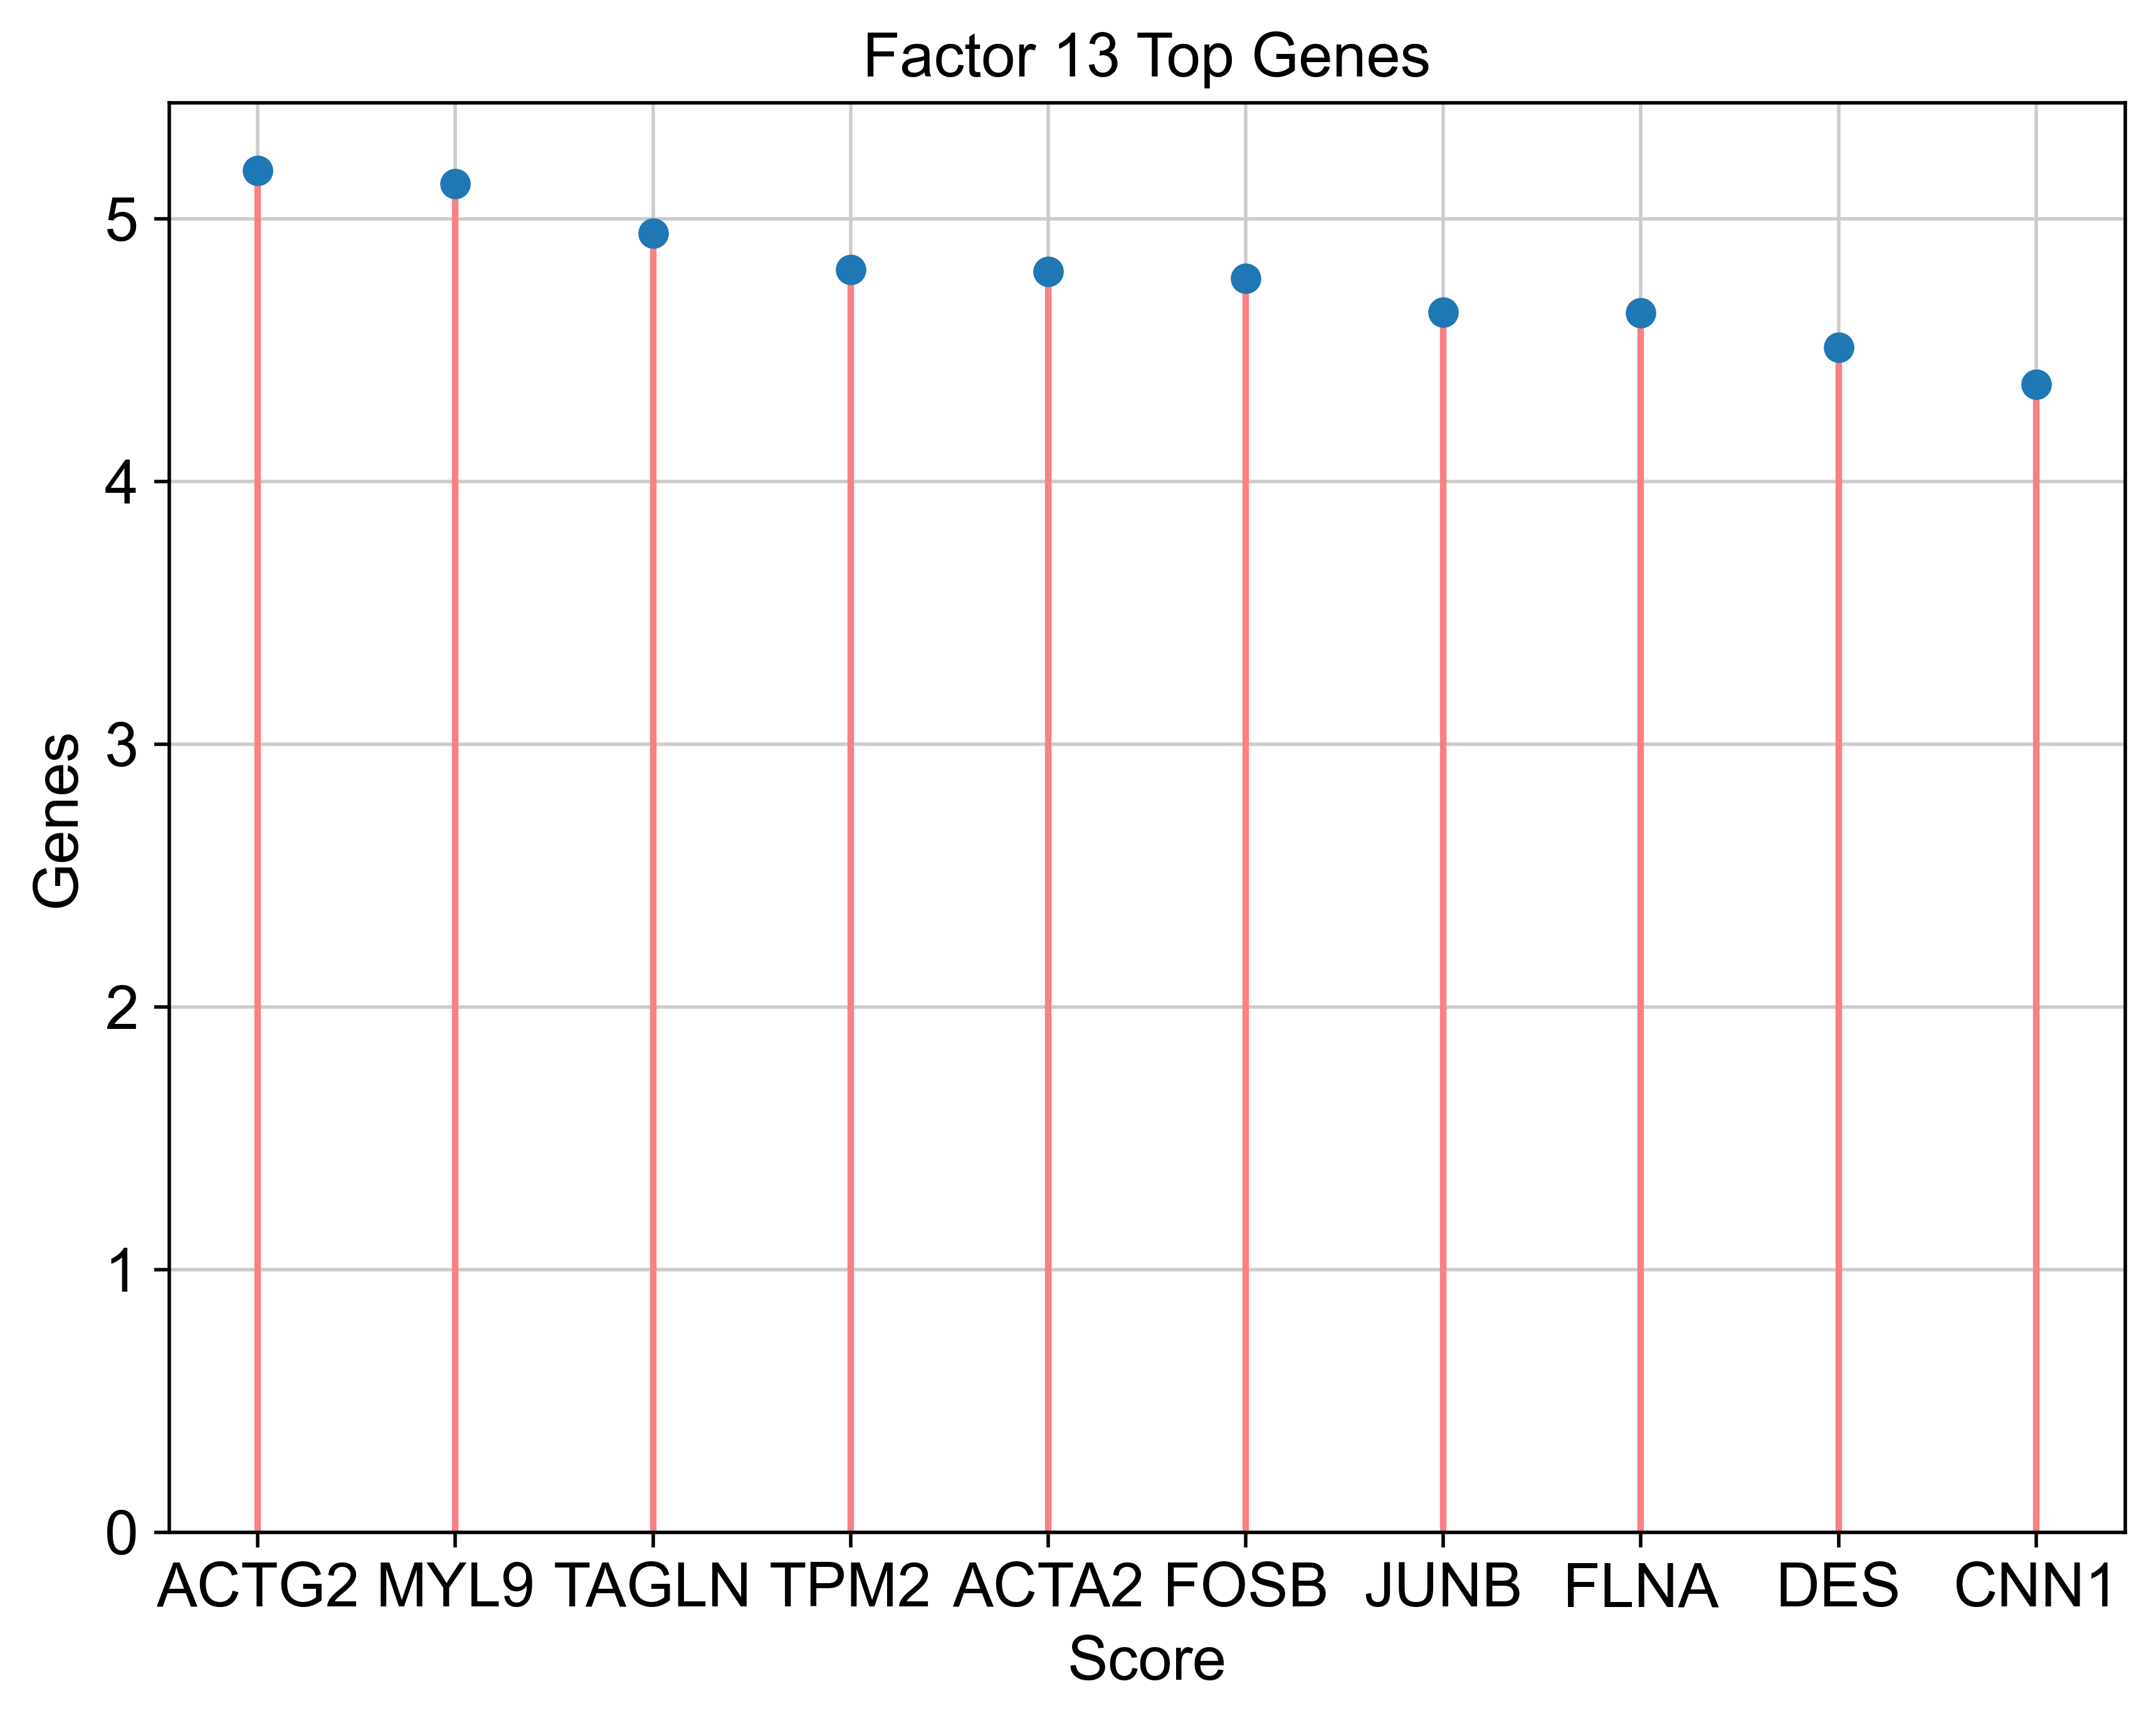

In [24]:

fig, axes = plt.subplots(figsize=(8, 6)) 
i=12
axes.vlines(mg[i]['Genes'].iloc[0:10], ymin=0, ymax=mg[i]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[i]['Genes'].iloc[0:10], mg[i]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
  
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 13 Top Genes') 
plt.xticks(mg[i]['Genes'].iloc[0:10])

([<matplotlib.axis.XTick at 0x330f0a060>,
 [Text(0.0, 0, 'FOSB'),
  Text(1.0, 0, 'TRIB1'),
  Text(2.0, 0, 'NR4A1'),
  Text(3.0, 0, 'ODC1'),
  Text(4.0, 0, 'NR4A2'),
  Text(5.0, 0, 'GDF15'),
  Text(6.0, 0, 'TCIM'),
  Text(7.0, 0, 'RANBP2'),
  Text(8.0, 0, 'VEGFA'),
  Text(9.0, 0, 'ACSL3')])

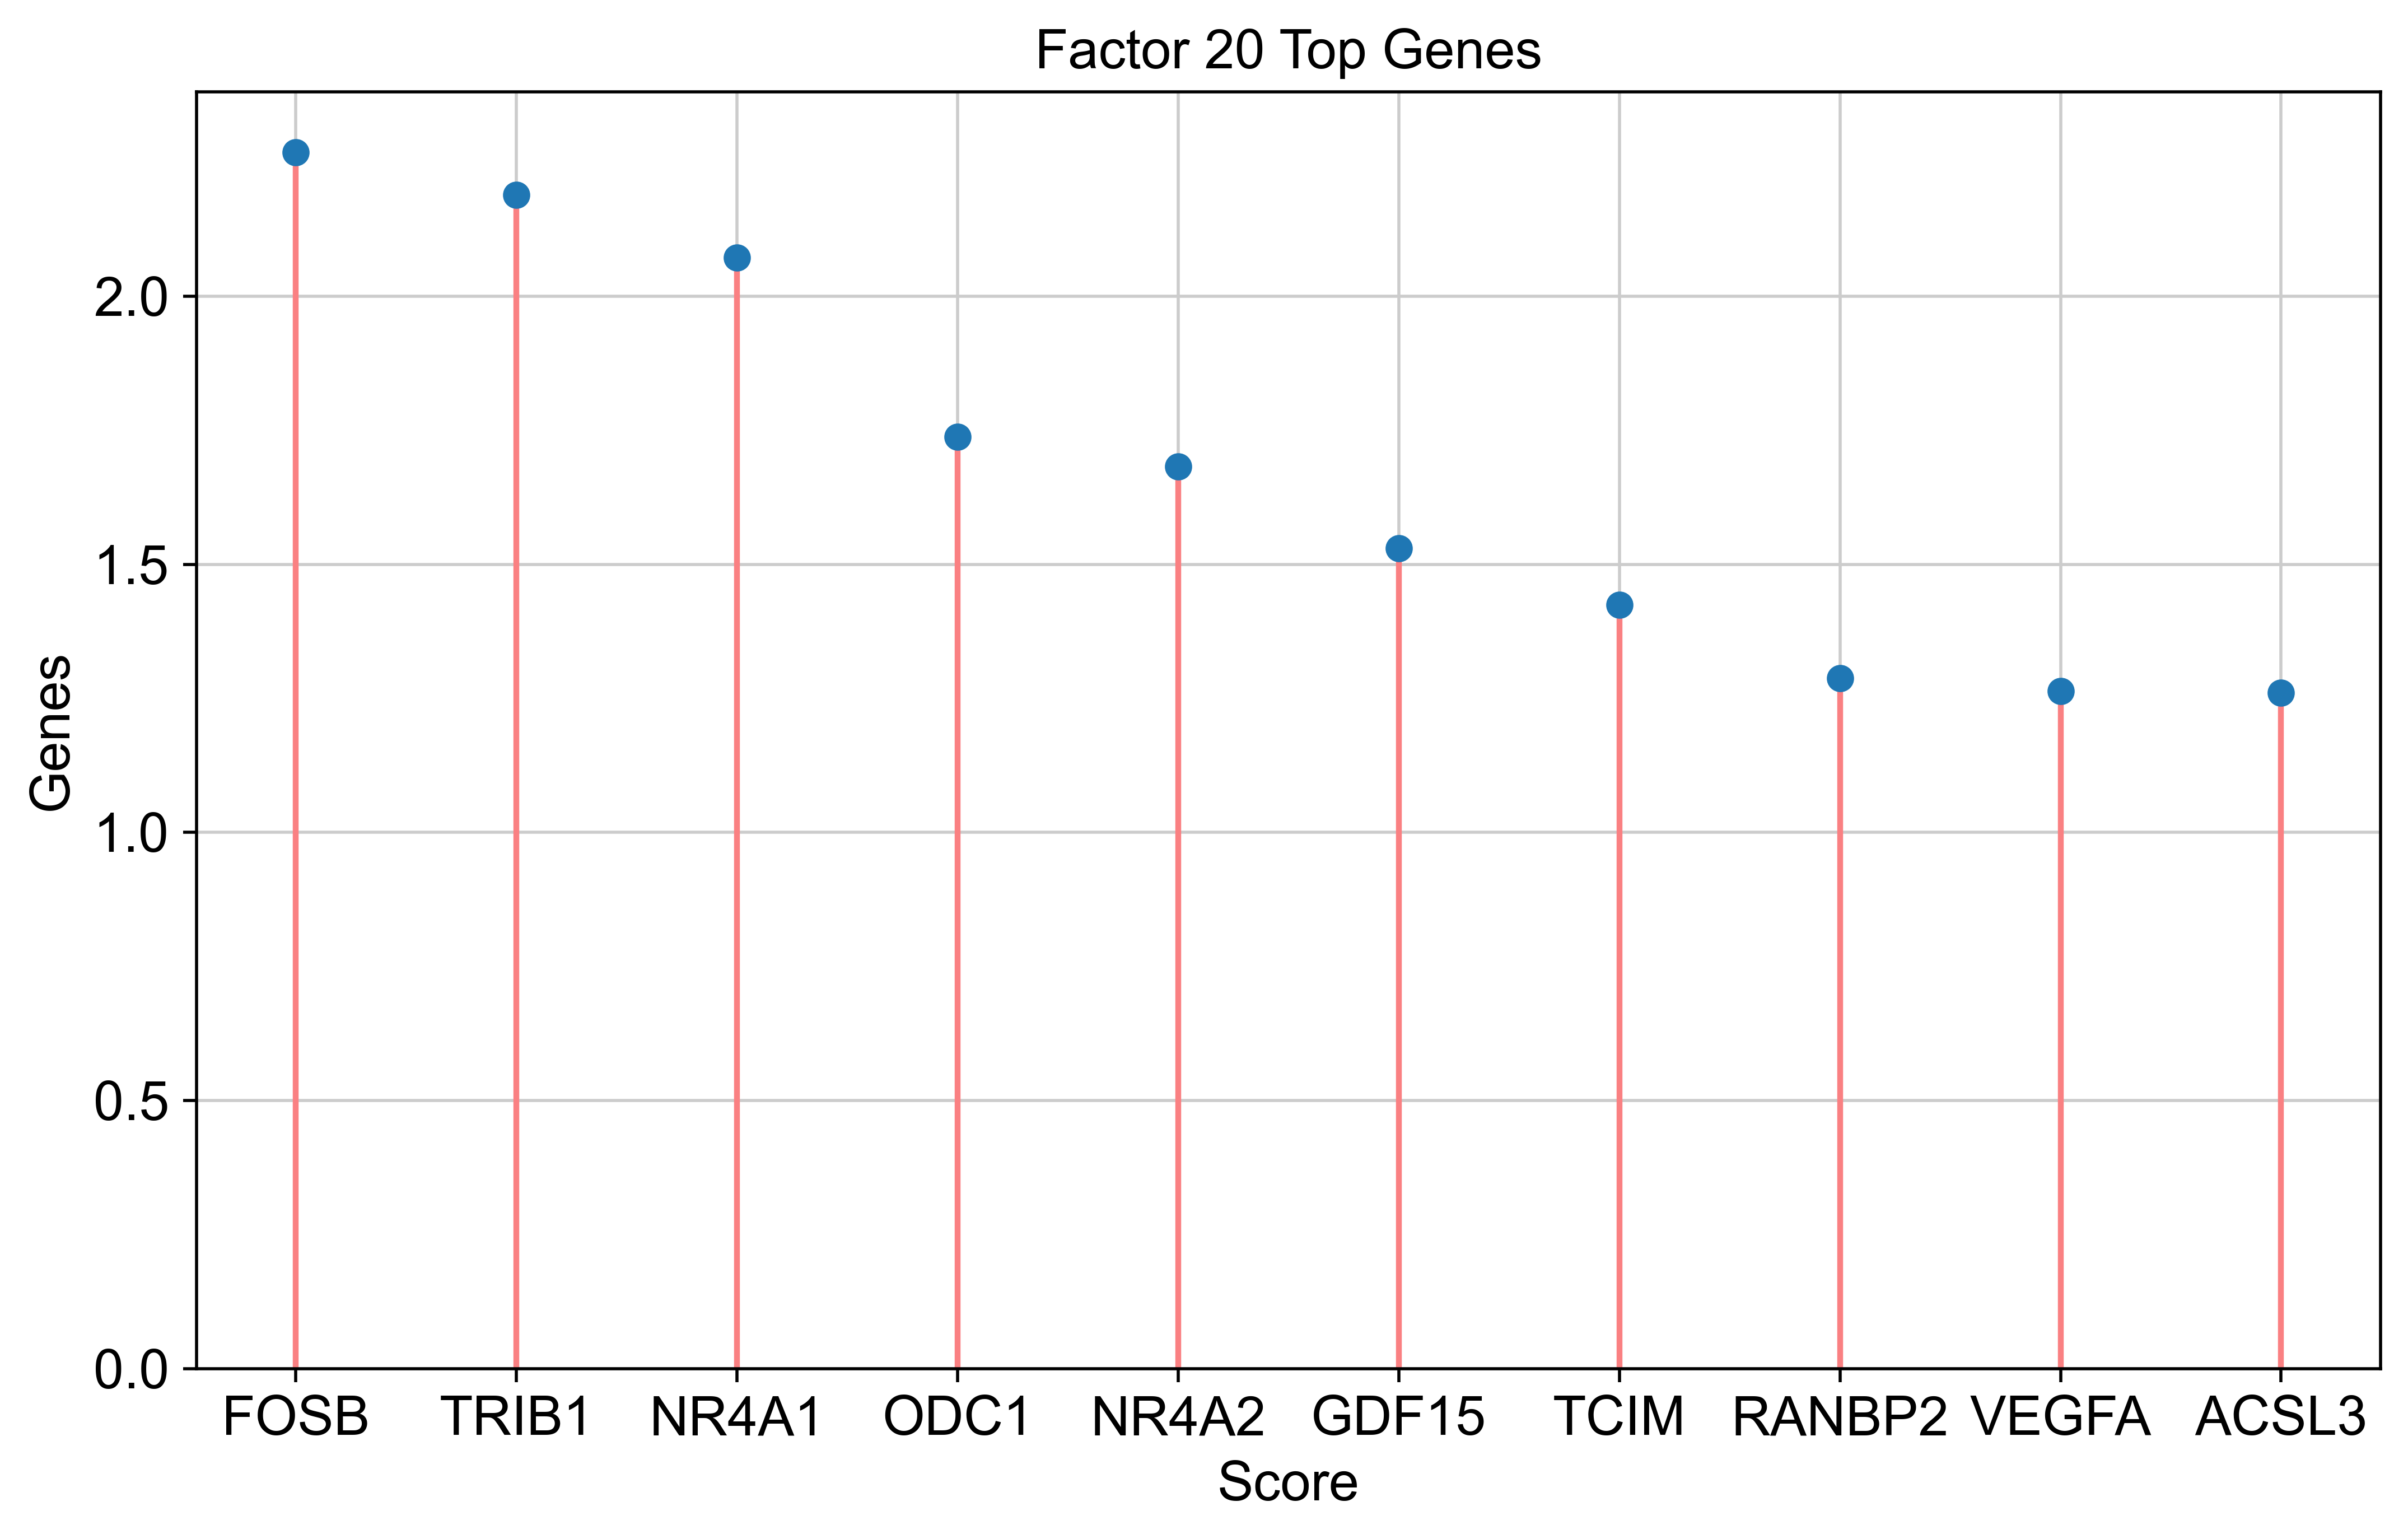

In [25]:

fig, axes = plt.subplots(figsize=(10, 6)) 
i=19
axes.vlines(mg[i]['Genes'].iloc[0:10], ymin=0, ymax=mg[i]['Topic score'].iloc[0:10],color='#FA8082')

axes.plot(mg[i]['Genes'].iloc[0:10], mg[i]['Topic score'].iloc[0:10], "o") 
axes.set_ylim(0) 
  
# formatting and details 
plt.xlabel('Score') 
plt.ylabel('Genes') 
plt.title('Factor 20 Top Genes') 
plt.xticks(mg[i]['Genes'].iloc[0:10])

In [26]:
df_ct = pd.DataFrame(ct)

In [75]:
def normalize_row_max(row):
    return row / row.max()

In [121]:
def normalize_min_max(df):
    return (df - df.min(axis=1).values[:, None]) / (df.max(axis=1) - df.min(axis=1)).values[:, None]


# Normalizing the dataframe
# normalized_df =df_ct.apply(lambda row: row / row.max(), axis=1)
normalized_df=normalize_row_max(df_ct)

In [122]:
# normalized_df = pd.DataFrame(normalized_df)
normalized_df = normalized_df.rename(columns={i: str(i + 1) for i in range(26)})



In [123]:
df_ct

0         1         2         3         4         5   \
B-cells        0.036566 -0.019739  0.143433  0.092153 -0.056103 -0.023328   
Club          -0.005197 -0.031545  0.803610 -0.006474 -0.200261 -0.045035   
Endothelial    0.025347 -0.030494  0.045484 -0.004786 -0.092654  0.000870   
Fibroblast    -0.009797 -0.067002  0.012615 -0.022090 -0.153068  0.055506   
LE             0.651401  0.110617  0.014054  0.024589  0.513089  0.019668   
Myeloid       -0.011072 -0.032563  0.148584  0.101526 -0.108807 -0.011611   
Neurons       -0.072196 -0.090727 -0.117577 -0.062226 -0.187634 -0.053873   
Smooth_muscle  0.070978 -0.029487  0.010840 -0.007503 -0.130201 -0.010672   
T-cells       -0.059450 -0.047158  0.043624  0.033525 -0.107905 -0.021563   
Tumor          0.251804  0.008109  0.036434  0.031747  0.619078  0.010515   

                     6         7         8         9   ...        16  \
B-cells        0.000648  0.063241  0.212255  0.006657  ...  0.160525   
Club          -0.035477  0.142809  0.158030  0.093993  ...  0.111935   
Endothelial    0.006373  0.074494  0.053380 -0.014557  ...  0.180761   
Fibroblast    -0.015872  0.258555  0.057881  0.012893  ...  0.935714   
LE             0.160150  0.208624  0.285392  0.786833  ...  0.162192   
Myeloid       -0.016564  0.091701  0.183138 -0.054380  ...  0.095811   
Neurons       -0.069353 -0.046361 -0.050186 -0.084063  ... -0.086215   
Smooth_muscle  0.027093  0.243990  0.084890  0.009461  ...  0.564618   
T-cells       -0.025925  0.003386  0.105306 -0.046864  ...  0.128406   
Tumor          0.160535  0.101816  0.140815  0.027284  ...  0.212932   

                     17        18        19        20        21        22  \
B-cells        0.005318  0.067278 -0.008006  0.051951  0.104759 -0.004821   
Club          -0.007570  0.228714 -0.058177 -0.154377  0.096259 -0.028710   
Endothelial   -0.023848  0.187788 -0.050908 -0.067397  0.068070 -0.001716   
Fibroblast    -0.011758  0.485051 -0.088678 -0.107692  0.421155  0.011026   
LE             0.225820  0.744701  0.009309  0.165385  0.136403  0.060108   
Myeloid       -0.011580  0.035833 -0.031015 -0.072704  0.059136 -0.012707   
Neurons       -0.089913  0.186592 -0.140664 -0.192066 -0.089909 -0.049706   
Smooth_muscle  0.009411  0.825685 -0.042838 -0.013376  0.221118 -0.000366   
T-cells       -0.038973  0.008846 -0.026366 -0.050329  0.023648 -0.018673   
Tumor          0.107412  0.043974  0.134112  0.340279  0.146556  0.004213   

                     23        24        25  
B-cells       -0.023241  0.029437 -0.037545  
Club           0.002600  0.046630 -0.054746  
Endothelial    0.032737  0.296032 -0.028191  
Fibroblast     0.140914  0.090830 -0.048089  
LE            -0.053987  0.018939 -0.006978  
Myeloid       -0.037040  0.032280 -0.060424  
Neurons       -0.110835 -0.062816 -0.099909  
Smooth_muscle  0.431541  0.165219 -0.045682  
T-cells       -0.024026  0.023943 -0.048285  
Tumor         -0.042724  0.038934  0.017160  

[10 rows x 26 columns]

In [124]:
normalized_df

1         2         3         4         5         6  \
B-cells        0.056134 -0.178447  0.178486  0.907673 -0.090623 -0.420279   
Club          -0.007978 -0.285171  1.000000 -0.063768 -0.323483 -0.811356   
Endothelial    0.038912 -0.275668  0.056600 -0.047139 -0.149664  0.015677   
Fibroblast    -0.015040 -0.605713  0.015698 -0.217582 -0.247251  1.000000   
LE             1.000000  1.000000  0.017488  0.242192  0.828795  0.354344   
Myeloid       -0.016997 -0.294375  0.184895  1.000000 -0.175757 -0.209175   
Neurons       -0.110831 -0.820193 -0.146311 -0.612909 -0.303086 -0.970567   
Smooth_muscle  0.108962 -0.266566  0.013489 -0.073900 -0.210314 -0.192266   
T-cells       -0.091265 -0.426319  0.054286  0.330206 -0.174299 -0.388473   
Tumor          0.386558  0.073304  0.045338  0.312702  1.000000  0.189443   

                      7         8         9        10  ...        17  \
B-cells        0.004037  0.244594  0.743732  0.008460  ...  0.171553   
Club          -0.220993  0.552337  0.553731  0.119457  ...  0.119625   
Endothelial    0.039696  0.288115  0.187040 -0.018500  ...  0.193180   
Fibroblast    -0.098867  1.000000  0.202811  0.016385  ...  1.000000   
LE             0.997603  0.806887  1.000000  1.000000  ...  0.173335   
Myeloid       -0.103181  0.354668  0.641706 -0.069113  ...  0.102393   
Neurons       -0.432015 -0.179307 -0.175851 -0.106837  ... -0.092139   
Smooth_muscle  0.168768  0.943670  0.297452  0.012024  ...  0.603409   
T-cells       -0.161490  0.013094  0.368987 -0.059560  ...  0.137228   
Tumor          1.000000  0.393790  0.493410  0.034675  ...  0.227562   

                     18        19        20        21        22        23  \
B-cells        0.023548  0.081481 -0.059699  0.152673  0.248743 -0.080198   
Club          -0.033522  0.276999 -0.433790 -0.453678  0.228560 -0.477640   
Endothelial   -0.105605  0.227433 -0.379590 -0.198064  0.161626 -0.028545   
Fibroblast    -0.052067  0.587452 -0.661223 -0.316482  1.000000  0.183434   
LE             1.000000  0.901919  0.069409  0.486028  0.323879  1.000000   
Myeloid       -0.051282  0.043398 -0.231263 -0.213660  0.140414 -0.211398   
Neurons       -0.398162  0.225984 -1.048854 -0.564437 -0.213482 -0.826940   
Smooth_muscle  0.041673  1.000000 -0.319420 -0.039309  0.525027 -0.006088   
T-cells       -0.172583  0.010713 -0.196599 -0.147904  0.056151 -0.310658   
Tumor          0.475655  0.053257  1.000000  1.000000  0.347986  0.070091   

                     24        25        26  
B-cells       -0.053856  0.099439 -2.187918  
Club           0.006025  0.157515 -3.190319  
Endothelial    0.075860  1.000000 -1.642808  
Fibroblast     0.326537  0.306825 -2.802360  
LE            -0.125103  0.063977 -0.406654  
Myeloid       -0.085832  0.109043 -3.521168  
Neurons       -0.256835 -0.212193 -5.822158  
Smooth_muscle  1.000000  0.558110 -2.662095  
T-cells       -0.055674  0.080880 -2.813758  
Tumor         -0.099004  0.131521  1.000000  

[10 rows x 26 columns]

In [125]:
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300,figsize=(50, 16))
ax=sns.heatmap(normalized_df.iloc[:,:],cmap = 'flare',annot=True,annot_kws={'size': 30})
ax.grid(False)
plt.savefig(f"/Users/user/Desktop/CellPie_paper/Revision/Revision_2/celltypes_prostate.png", bbox_inches="tight") 
